#INFO and imports

**Moutning google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np


DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"

IMAGES = np.load(f'{DDSM_dir}/training/images.npy', allow_pickle=True)
MASKS = np.load(f'{DDSM_dir}/training/masks.npy', allow_pickle=True)

print(IMAGES.shape)
print(MASKS.shape)

(3568, 256, 256, 1)
(3568, 256, 256, 1)


In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping

#utils

##**Metrics**

Mean IOU

In [ ]:
def mean_iou(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_coef(y_true, y_pred):
  smooth = K.epsilon() ##
  thr = 0.5 ###
  y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # apply threshold to prediction
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  return K.mean((intersection + smooth) / (union + smooth), axis=0)

Pixel accuracy

In [ ]:
def pixel_accuracy(y_true, y_pred):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.round(tf.reshape(y_pred, [-1]))  # round to get 0 or 1 prediction
    
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32))
    total_pixels = tf.cast(tf.size(y_true_f), tf.float32)
    
    return correct_pixels / total_pixels

Pescision and Recall

In [ ]:
def recall(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + smooth)
  return recall

def precision(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + smooth)
  return precision

F1 score

In [ ]:
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    # Ensure the F1 score is defined even when precision and recall are 0
    if p + r == 0:
        return 0.0

    f1 = 2 * ((p * r) / (p + r))
    return f1

In [ ]:
metrics = [iou_coef,
           mean_iou,
           #pixel_accuracy,
           recall,
           precision,
           f1]

##**Loss**

Dice Loss

In [ ]:
def dice_coef(y_true, y_pred, smooth=.1):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection) / (K.sum(K.square(y_true)) + K.sum(K.square(y_pred)) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


IOU loss

In [ ]:
def iou_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred)

##**Optimizers**

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

##**callbacks**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callback= [ModelCheckpoint('/content/drive/MyDrive/models/unet4.h5',verbose =1, save_best_only=True),
    EarlyStopping(patience = 20, verbose =1, restore_best_weights=True ,monitor = "val_loss")]

#Model

In [ ]:
def unet(input_size = (256,256,1) , sart_neurons = 32):
    inputs = Input(input_size)
    conv1 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(sart_neurons * 16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(sart_neurons * 16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(sart_neurons * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
        
    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[output_layer])
    return model

In [ ]:
model = unet()

In [ ]:
model.compile('adam', loss=dice_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 32  128        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


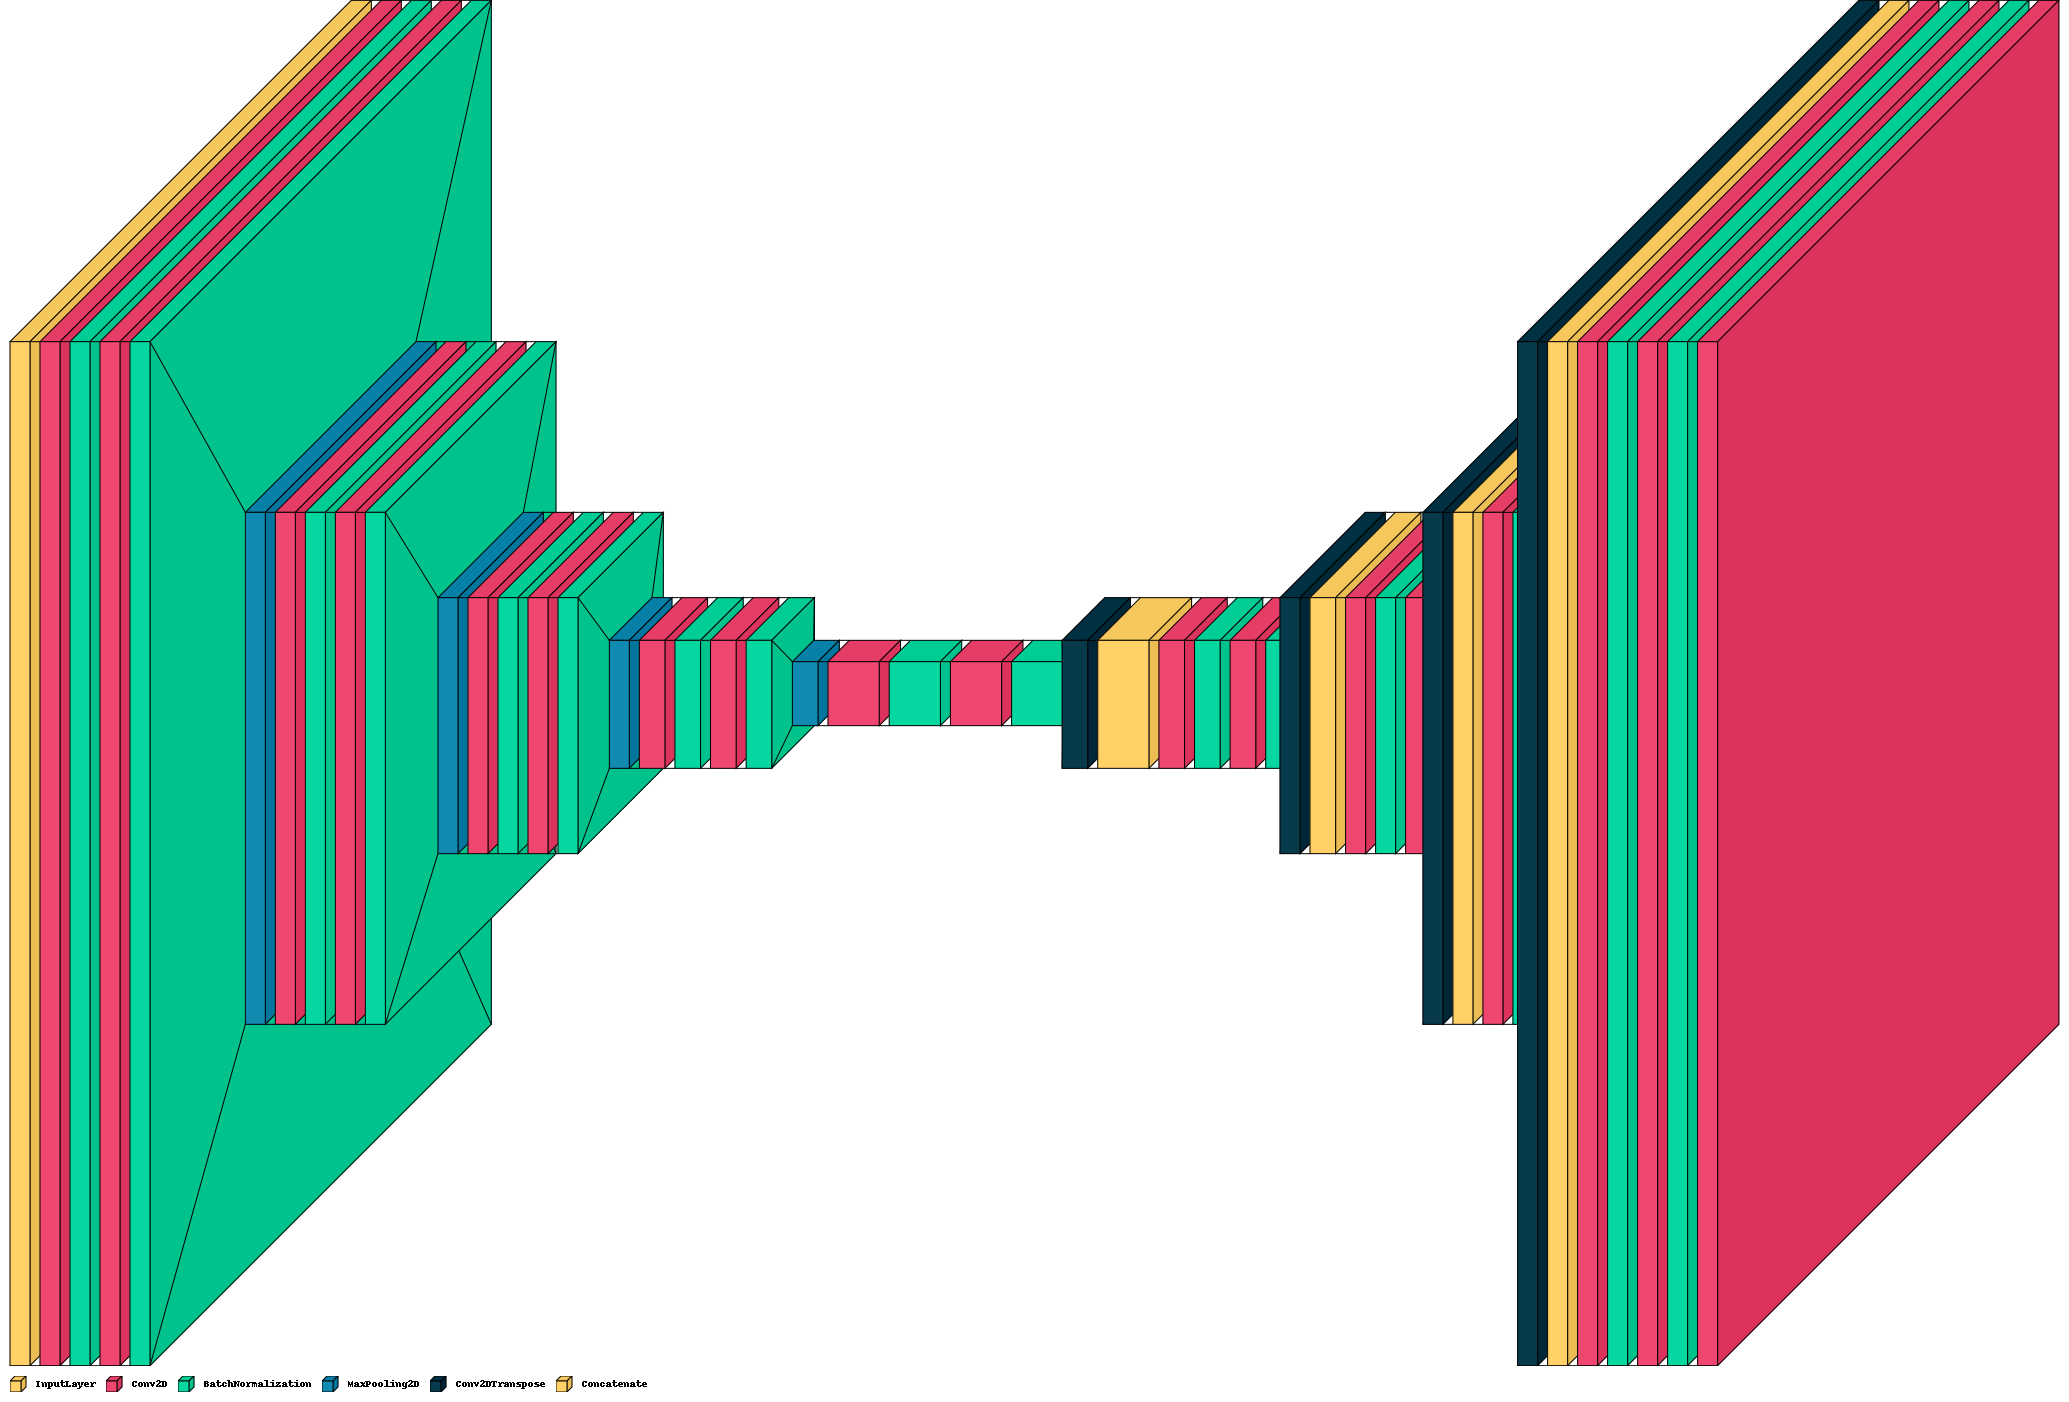

In [ ]:
import visualkeras
visualkeras.layered_view(model,legend=True, draw_volume=True)

#**Fitting**

##Training

In [ ]:
from sklearn.model_selection import train_test_split

IMAGES_sub = np.split(IMAGES, 1)[0] ## remvoe this
MASKS_sub = np.split(MASKS, 1)[0] ## remove this


# Split dataset into train and test sets (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(IMAGES_sub, MASKS_sub, test_size=0.2, random_state=42)

# Split training set into train and validation sets (80/20 split)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

batch_size = 1 ##
train_steps = x_train.shape[0] // batch_size
test_steps = x_val.shape[0] // batch_size

history = model.fit(x=x_train, 
          y=y_train, 
          epochs=100,
          steps_per_epoch = train_steps, 
          validation_steps= test_steps ,
          shuffle=True,
          callbacks = callback,
          batch_size = batch_size, 
          validation_data=(x_val, y_val))

Epoch 1/100
2282/2283 [============================>.] - ETA: 0s - loss: 0.8449 - iou_coef: 0.9573 - mean_iou: 0.0359 - recall: 0.1950 - precision: 0.1111 - f1: 0.0906
Epoch 1: val_loss improved from inf to 0.84178, saving model to /content/drive/MyDrive/m3.h5
2283/2283 [==============================] - 107s 34ms/step - loss: 0.8449 - iou_coef: 0.9572 - mean_iou: 0.0359 - recall: 0.1950 - precision: 0.1110 - f1: 0.0905 - val_loss: 0.8418 - val_iou_coef: 0.9835 - val_mean_iou: 0.0317 - val_recall: 0.0379 - val_precision: 0.0873 - val_f1: 0.0303
Epoch 2/100
2282/2283 [============================>.] - ETA: 0s - loss: 0.8141 - iou_coef: 0.9785 - mean_iou: 0.0418 - recall: 0.1381 - precision: 0.1528 - f1: 0.1053
Epoch 2: val_loss improved from 0.84178 to 0.82673, saving model to /content/drive/MyDrive/m3.h5
2283/2283 [==============================] - 74s 32ms/step - loss: 0.8141 - iou_coef: 0.9785 - mean_iou: 0.0418 - recall: 0.1381 - precision: 0.1528 - f1: 0.1053 - val_loss: 0.8267 - v

##Prediction

**Function ploting samples of the predectied**

In [ ]:
from matplotlib import pyplot as plt

def plot_image(img):
  plt.imshow(img.reshape(256,256), interpolation='nearest')
  plt.show()
  return plt

def plot_prediction(y_pred, num_samples=5):
    # Choose random indices
    indices = np.random.choice(np.arange(y_pred.shape[0]), size=num_samples, replace=False)
    
    for idx in indices:
        # Get data
        x = x_test[idx]
        true = y_test[idx] # true mask
        pred = y_pred[idx]
        binary_pred = np.where(pred > 0.5, 1, 0) #pred after post proccessing


        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot original image
        axs[0].imshow(x)
        axs[0].set_title("Original Image")

        # Plot prediction
        axs[1].imshow(pred.squeeze(), cmap='gray')
        axs[1].set_title("Predicted")

        # Plot binary prediction
        axs[2].imshow(binary_pred.squeeze(), cmap='gray')
        axs[2].set_title("Binary Predicted")


        # Plot ground truth
        axs[3].imshow(true.squeeze(), cmap='gray')
        axs[3].set_title("Ground Truth")


        # Hide the axes
        for ax in axs:
            ax.axis('off')

        plt.show()

**prediction**

In [ ]:
predicted = model.predict(x_test)

23/23 [==============================] - 7s 271ms/step


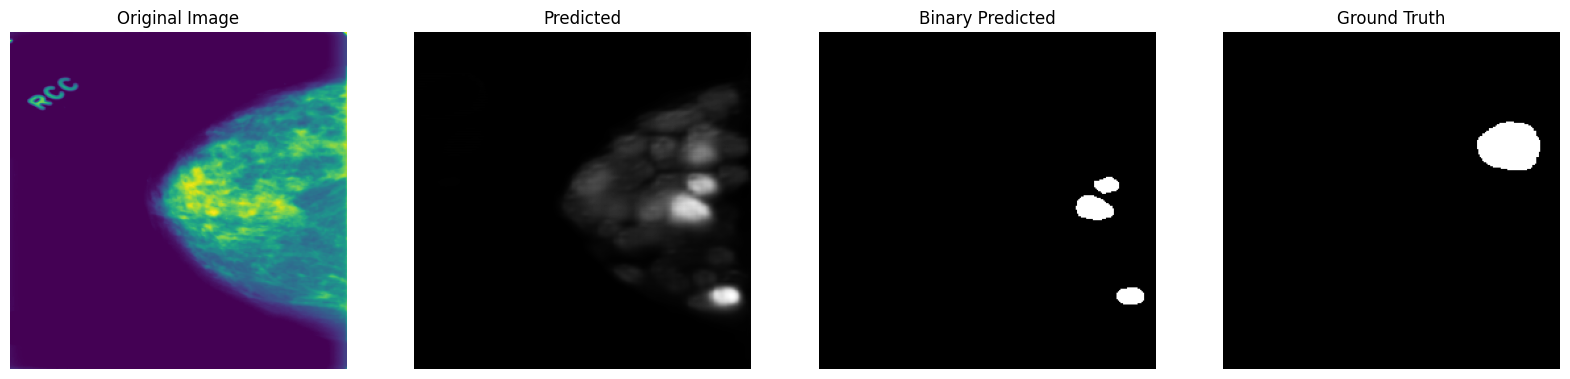

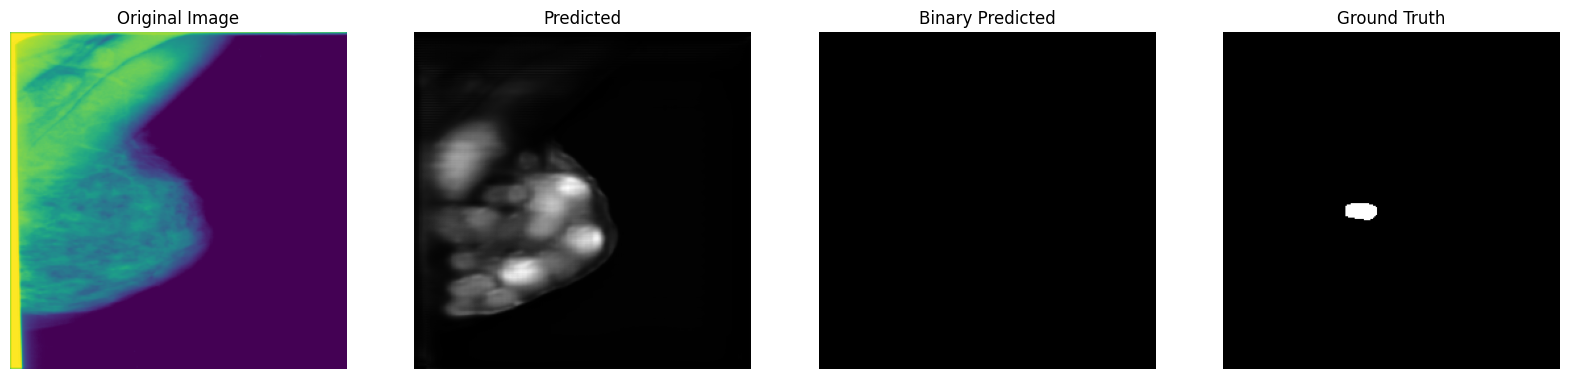

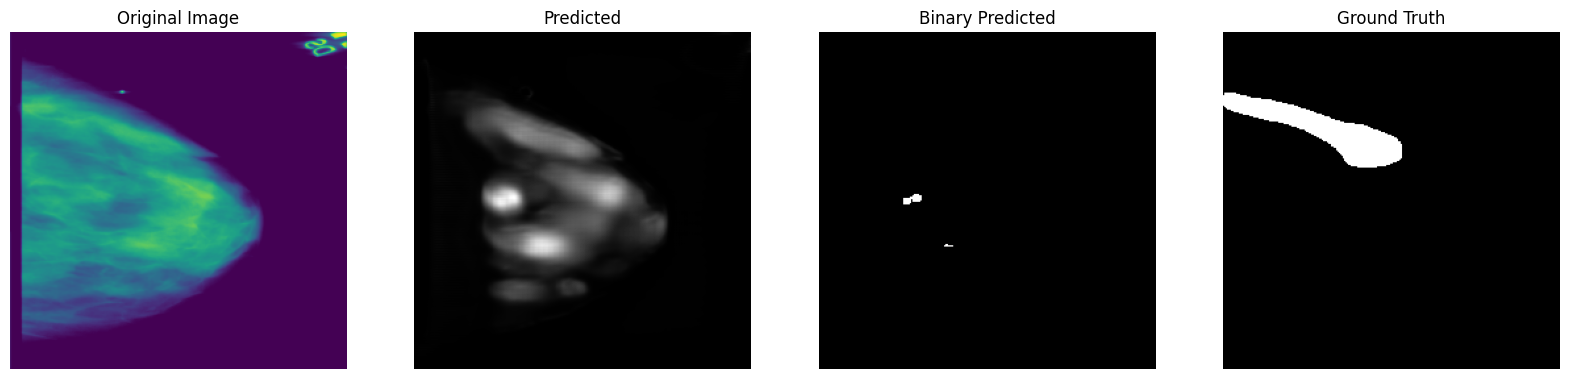

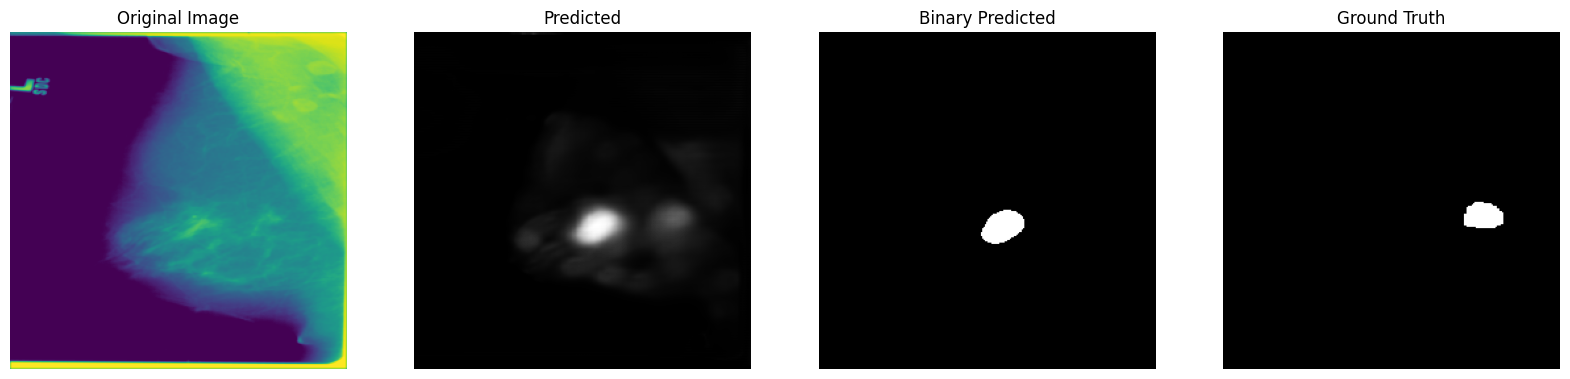

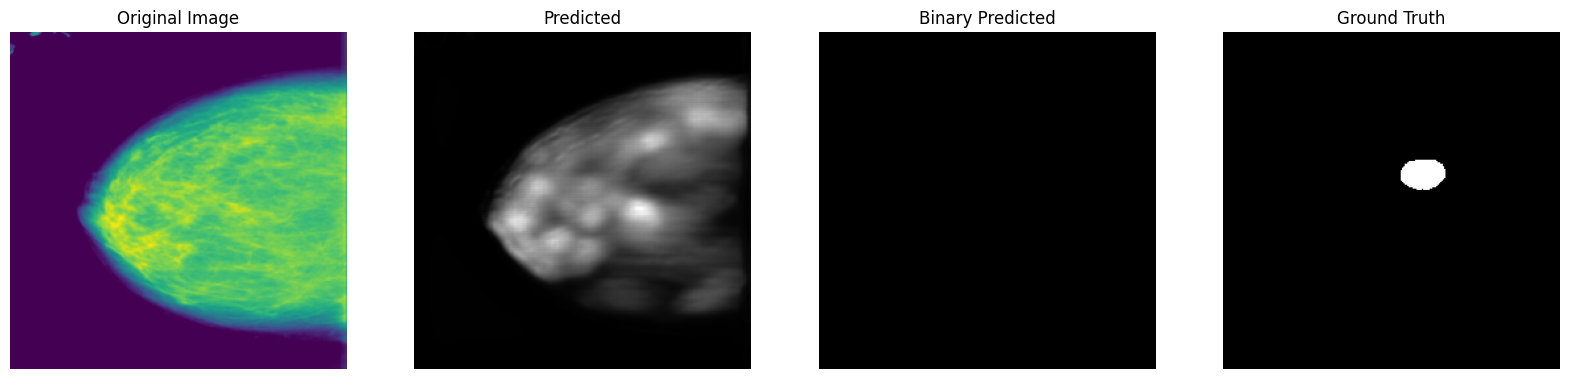

In [ ]:
plot_prediction(predicted)

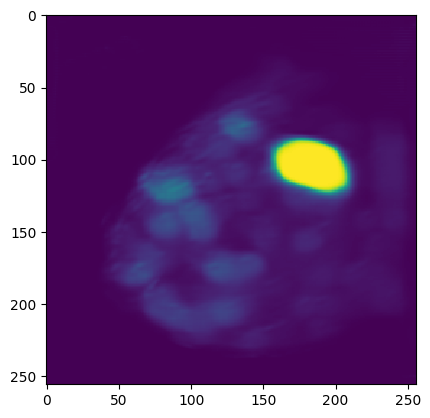

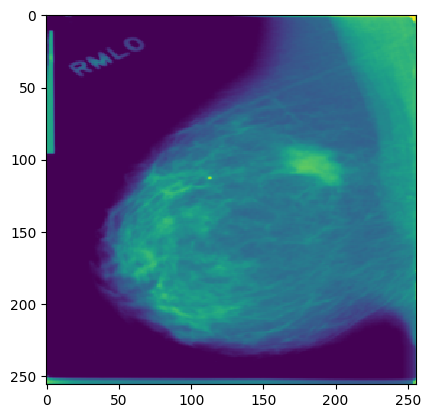

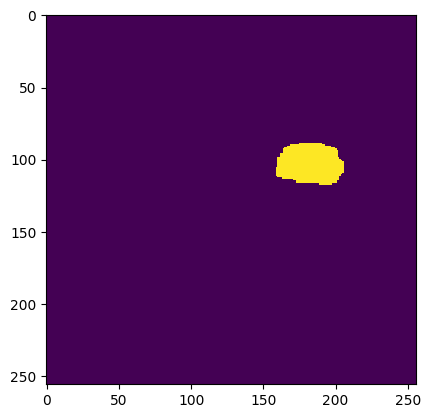

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
sample = 2
plot_image(predicted[sample])
plot_image(x_test[sample])
plot_image(y_test[sample])

In [ ]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/models/unet4.h5')

ValueError: ignored

In [ ]:
history = model.history 
history.params

{'verbose': 1, 'epochs': 1, 'steps': 23}

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

batch_size = 1 ##
train_steps = x_train.shape[0] // batch_size
test_steps = x_val.shape[0] // batch_size

history = model.fit(x=x_train, 
          y=y_train, 
          epochs=100,
          steps_per_epoch = train_steps, 
          validation_steps= test_steps ,
          shuffle=False,
          callbacks = callback,
          batch_size = batch_size, 
          validation_data=(x_val, y_val))

Epoch 1/100
2283/2283 [==============================] - ETA: 0s - loss: 0.6935 - iou_coef: 0.9823 - mean_iou: 0.0959 - recall: 0.2917 - precision: 0.2792 - f1: 0.2495
Epoch 1: val_loss did not improve from 0.75003
2283/2283 [==============================] - 72s 32ms/step - loss: 0.6935 - iou_coef: 0.9823 - mean_iou: 0.0959 - recall: 0.2917 - precision: 0.2792 - f1: 0.2495 - val_loss: 0.7584 - val_iou_coef: 0.9863 - val_mean_iou: 0.0659 - val_recall: 0.1418 - val_precision: 0.1706 - val_f1: 0.1298
Epoch 2/100
2282/2283 [============================>.] - ETA: 0s - loss: 0.6875 - iou_coef: 0.9826 - mean_iou: 0.0995 - recall: 0.2969 - precision: 0.2861 - f1: 0.2560
Epoch 2: val_loss did not improve from 0.75003
2283/2283 [==============================] - 74s 32ms/step - loss: 0.6875 - iou_coef: 0.9826 - mean_iou: 0.0995 - recall: 0.2968 - precision: 0.2863 - f1: 0.2559 - val_loss: 0.7842 - val_iou_coef: 0.9867 - val_mean_iou: 0.0619 - val_recall: 0.1114 - val_precision: 0.1388 - val_f1: